## Automated Machine Learning
We will be working with [Heart Failure Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).

### Libraries
- [HyperOpt](https://hyperopt.github.io/hyperopt/) ([Tutorial 1](https://towardsdatascience.com/optimise-your-hyperparameter-tuning-with-hyperopt-861573239eb5), [Tutorial 2](https://medium.com/vooban-ai/hyperopt-tutorial-for-optimizing-neural-networks-hyperparameters-e3102814b919))


### Instructions
1. Choose a dataset. Build and train a baseline for comparison. Try a set of possible machine learning algorithms (13 algorithms) using their default hyperparamters and choose the one with the highest performance for comparison.

2. Based on the problem at hand, you study the potential pipeline structure,
algorithms or feature transformers at each step, hyper-parameters ranges. Use
hyperOpt with the potential search space to beat the baseline.

3. Monitor the performance of you the constructed pipeline from the previous step across different time budgets (number of iterations) and report the least time budget that you are able to outperform the baseline.

4. Determine whether the difference in performance between the constructed pipeline and the baseline is statistically significant.

In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import seaborn as sn

In [2]:
df = pd.read_csv('./heart_failure.csv')
df.sample(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
687,70,M,ATA,156,245,0,LVH,143,N,0.0,Up,0
827,43,F,NAP,122,213,0,Normal,165,N,0.2,Flat,0
574,69,M,ASY,142,210,1,ST,112,Y,1.5,Flat,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
%%capture --no-display
from sklearn.model_selection import train_test_split
from util import find_baseline, preprocess

df = preprocess(df)
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)
scores = find_baseline(train_df)

In [5]:
for name, score in sorted(scores.items(), key=lambda t: t[1], reverse=True):
    print(f'{name:20}: {score:.3f}')

Naive Bayes         : 0.850
Gradient Boosting   : 0.849
Random Forest       : 0.844
AdaBoost            : 0.844
Logistic Regression : 0.844
LDA                 : 0.837
QDA                 : 0.833
SVM                 : 0.831
Neural Network      : 0.823
Bagging Classifier  : 0.816
Decision Tree       : 0.802
Gaussian Process    : 0.746
KNN                 : 0.712


In [6]:
baseline_model_name = max(scores, key=scores.get)
baseline_score = scores[baseline_model_name]
print(f"Baseline model is {baseline_model_name} with accuracy {baseline_score:.4f}.")

Baseline model is Naive Bayes with accuracy 0.8504.


In [7]:
%%capture --no-display
from util import get_min_budgets, search_spaces
from sklearn.preprocessing import StandardScaler

X_train = train_df.drop('HeartDisease', axis=1).values
X_test = test_df.drop('HeartDisease', axis=1).values

y_train = train_df['HeartDisease'].values
y_test = test_df['HeartDisease'].values

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

min_budget_score, model_predictions = get_min_budgets(X_train, X_test, y_train, y_test, search_spaces.keys(), baseline_score, train_df)
min_budget_score

,Classifier,Minimum_Budget,Accuracy
0,Gradient Boosting,1,0.874587
1,Bagging Classifier,1,0.871287
2,LDA,100,0.848185
3,QDA,1,0.854785
4,Naive Bayes,1,0.871287
5,KNN,100,0.742574
6,SVM,1,0.851485
7,Gaussian Process,1,0.851485
8,Decision Tree,38,0.861386
9,Neural Network,100,0.844884


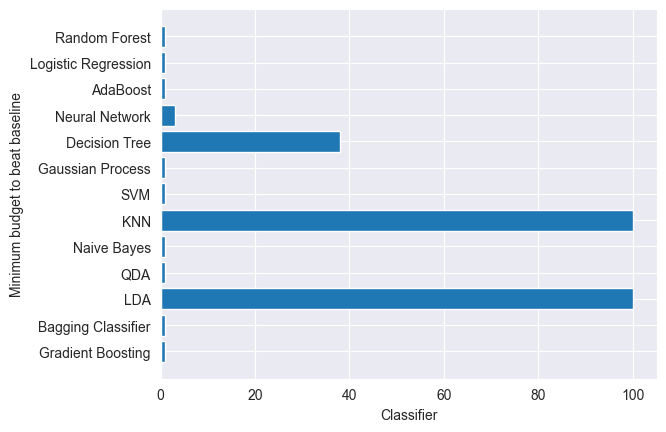

In [15]:
from matplotlib import pyplot as plt

plt.barh(min_budget_score['Classifier'], min_budget_score['Minimum_Budget'])
plt.xlabel("Classifier")
plt.ylabel("Minimum budget to beat baseline")
plt.show()

In [9]:
from util import models
from scipy.stats import ttest_ind

# Fit the baseline model to the train and test data that hyperopt used
baseline_model = models[baseline_model_name]
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)

# add / readd a column for p-value in the budget/score db
if 'p-value' in min_budget_score.columns:
    del min_budget_score['p-value']
min_budget_score.insert(len(min_budget_score.columns), 'p-value', None)

# calculate and add p-values to db
for classifier in model_predictions.keys():
    t_result = ttest_ind(model_predictions[classifier], baseline_pred)
    min_budget_score.loc[(min_budget_score['Classifier'] == classifier), 'p-value'] = t_result.pvalue

min_budget_score


,Classifier,Minimum_Budget,Accuracy,p-value
0,Gradient Boosting,1,0.874587,0.935062
1,Bagging Classifier,1,0.871287,0.625427
2,LDA,100,0.848185,0.569083
3,QDA,1,0.854785,0.567233
4,Naive Bayes,1,0.871287,1.0
5,KNN,100,0.742574,0.683051
6,SVM,1,0.851485,0.744715
7,Gaussian Process,1,0.851485,1.0
8,Decision Tree,38,0.861386,0.08356
9,Neural Network,100,0.844884,0.515302


In [10]:
from matplotlib import pyplot as plt

def visualise_search(losses, baseline):
    baseline = 1 - baseline
    plt.plot(range(len(losses)), losses, linewidth=0.8, alpha=0.5)
    plt.plot([0, len(losses)], [baseline, baseline], linestyle='dashed', linewidth=0.5, color='red', alpha=0.8)
    plt.ylim(0, 0.2)
    plt.show()
